# Manipulate data
In this notebook the reference data and the user data are manipulated

In [1]:
#Imports
import json
import geopandas as gpd
from shapely import Polygon, MultiPolygon

## Reference countries
I used the following dataset <br>https://public.opendatasoft.com/explore/dataset/country_shapes/information/?location=2,-32.99024,1.40625&basemap=jawg.light<br> for the country reference shapes. The cells below contain the modification made to the data. 

In [ ]:
ref_gdf = gpd.read_file('./data/reference.geojson')
ref_gdf

### DONE: Remove small islands seperated from the mainland
Some countries, like Chile and Denmark, have a small island that is seperated from the mainland by a large distane. 
Lets remove these "outliers"

In [ ]:
def rm_outlier(geom, min_length=0.8, min_area=0.05):
    if isinstance(geom, Polygon):
        return geom

    #Get current geom boundary length 
    xmin, ymin, xmax, ymax = geom.bounds
    geom_length = (xmax - xmin) + (ymax - ymin)
        
    polygons = [poly for poly in geom.geoms]
    new_polygons = []
    for idx in range(len(polygons)):
        subset = polygons.copy()
        poly = subset.pop(idx)
        new_geom = MultiPolygon(subset)
        xmin, ymin, xmax, ymax = new_geom.bounds
        length = (xmax - xmin) + (ymax - ymin)
        #Check if the polygon should be omitted 
        if (length / geom_length) > min_length or (poly.area / geom.area) > min_area:
            new_polygons.append(poly)
    
    return MultiPolygon(new_polygons)

In [ ]:
ref_gdf['geometry'] = ref_gdf['geometry'].apply(rm_outlier)

In [ ]:
ref_gdf.to_file('./data/reference.geojson')

### DONE: Change map projection
The projection used in the reference dataset seems to be the equirectangular projection. This leads to deformed country shapes, especially around the poles.

In [ ]:
ref_gdf = ref_gdf[ref_gdf.cntry_name != 'Antarctica'].reset_index(drop=True)

In [ ]:
from pyproj import Proj, Transformer 
from shapely.ops import transform

In [ ]:
def change_projection(polygon):
    source_proj = Proj(init='EPSG:4326')  # WGS84 geographic coordinate system
    target_proj = Proj(init='EPSG:3857')  # Web Mercator projection
    transformer = Transformer.from_proj(source_proj, target_proj)

    return transform(transformer.transform, polygon)

In [ ]:
ref_gdf['geometry'] = ref_gdf['geometry'].apply(change_projection)

In [ ]:
#ref_gdf.to_file('./data/reference.geojson')

### DONE: Merge Russia
Russia crosses the antimeridian which causes problems. Lets fix this

In [ ]:
from shapely.affinity import translate


def fix_russia(russia):
    xmin, _, xmax, _ = russia.bounds
    width = xmax - xmin
    polygons = []
    for poly in russia.geoms:
        _, _, maxx, _ = poly.bounds
        if maxx < 0:
            poly = translate(poly, xoff=width)
        polygons.append(poly)

    russia = polygons[0]
    for poly in polygons[1:]:
        russia = russia.union(poly)
    return russia

In [ ]:
ref_gdf.loc[ref_gdf['cntry_name']=='Russia', 'geometry'] = fix_russia(ref_gdf.loc[ref_gdf["cntry_name"]=='Russia']['geometry'].item())

In [ ]:
#ref_gdf.to_file('./data/reference.geojson')

### Done: Filter countries with sparse area
Lets filter out the countries wich are extremly sparse 

In [ ]:
def filter_coverage(geom, minimum=0.02):
    xmin, ymin, xmax, ymax = geom.bounds
    bounding_area = (ymax - ymin) * (xmax - xmin)
    coverage = geom.area / bounding_area
    return coverage > minimum

In [ ]:
ref_gdf = ref_gdf[ref_gdf['geometry'].apply(filter_coverage)].reset_index(drop=True)

In [ ]:
#ref_gdf.to_file('./data/reference.geojson')

### DONE: Decompose Polygon into MultiPolygon

In [ ]:
def to_MultiPolygon(polygon):
    if isinstance(polygon, Polygon):
        return MultiPolygon([polygon])
    return polygon

In [ ]:
ref_gdf['geometry'] = ref_gdf['geometry'].apply(to_MultiPolygon)

In [ ]:
#ref_gdf.to_file('./data/reference.geojson')

### DONE: Filter countries with very few points
Some countries consists of very few points. These are not accurate enough 

In [ ]:
def filter_few_points(geom, minimum=25):
    if isinstance(geom, Polygon):
        points = len(geom.exterior.coords)
    if isinstance(geom, MultiPolygon):
        points = sum([len(poly.exterior.coords) for poly in geom.geoms])
    return points > minimum

In [ ]:
ref_gdf = ref_gdf[ref_gdf['geometry'].apply(filter_few_points)].reset_index(drop=True)

In [ ]:
#ref_gdf.to_file('./data/reference.geojson')

### DONE: Decompose single file
All the reference shapes are in a single geojson file. This limits git in proper version control of the data. 
As such I decompose the single geojson file into one file for each reference shape.

In [ ]:
def decompose_ref_geojson(file='./data/reference.geojson', output_dir='./data/reference/'):
    # Create output directory if it doesn't exist
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    ref_gdf = gpd.read_file(file)
    files = set()

    # Process each country
    for idx, row in ref_gdf.iterrows():
        # Create a clean filename from country name
        country_name = row['cntry_name']
        filename = country_name.lower().replace(' ', '_') + '.geojson'

        # Make sure no duplicate filenames 
        assert filename not in files
        files.add(filename)

        # Create GeoJSON feature with CRS information
        geojson = {
            "type": "FeatureCollection",
            "crs": {
                "type": "name",
                "properties": {
                    "name": "urn:ogc:def:crs:OGC:1.3:CRS84"
                }
            },
            "features": [{
                "type": "Feature",
                "properties": {
                    "country_name": country_name,
                },
                "geometry": row['geometry'].__geo_interface__
            }]
        }
        
        # Save to file
        with open(Path(output_dir) / filename, 'w') as f:
            json.dump(geojson, f, indent=2)

In [10]:
#decompose_ref_geojson('./data/reference.geojson', './data/reference/')

## User drawings

In [2]:
import matplotlib.pyplot as plt
from countryguess.data import TestDataset, Dataset, poly_to_img

In [3]:
test_data = TestDataset(shape=(128, 128))
test_data.gdf

,country_name,timestamp,geometry
0,Denmark,2024-04-13 15:24:33.402,"MULTILINESTRING ((13.63326 13.10448, 13.63326 ..."
1,Cameroon,2024-04-13 18:35:43.835,"MULTILINESTRING ((92.1949 126, 90.18097 125.71..."
2,Chile,2024-04-13 18:49:01.942,"MULTILINESTRING ((52.04193 126, 52.04193 124.1..."
3,Peru,2024-04-13 18:50:25.626,"MULTILINESTRING ((12.37175 91.88848, 15.59851 ..."
4,Venezuela,2024-04-13 18:52:13.828,"MULTILINESTRING ((14.87692 105.01538, 12.49231..."
...,...,...,...
74,United States of America,2025-02-28 14:04:56.031,"MULTILINESTRING ((118.35854 104.29132, 120.442..."
75,Uruguay,2025-02-28 14:08:18.771,"MULTILINESTRING ((11.92 116.43429, 16.88 115.7..."
76,Egypt,2025-02-28 14:10:03.298,"MULTILINESTRING ((2.65263 117.51579, 2.65263 1..."
77,Brazil,2025-03-31 08:20:07.008,"MULTILINESTRING ((71.33005 6.27586, 71.33005 8..."


### Plot user drawings

In [4]:
ref_data = Dataset(shape=(128, 128))

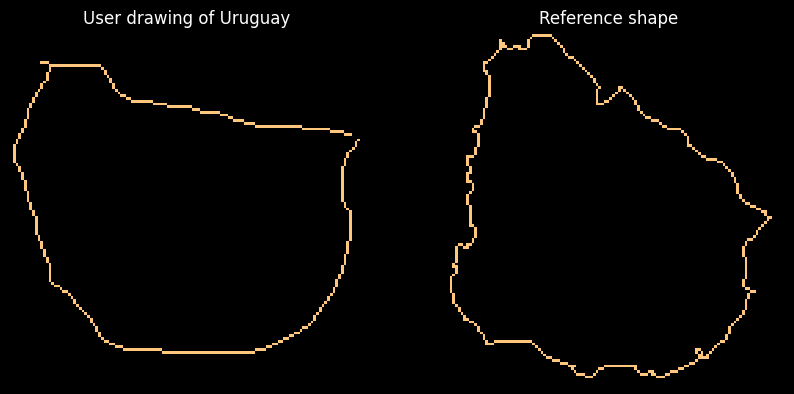

In [9]:
sample = test_data[-4]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.patch.set_facecolor('black')
axs[0].imshow(sample["drawing"], interpolation='nearest', origin='lower', cmap='copper')
axs[0].set_title(f"User drawing of {sample['country_name']}", color='white')

img = poly_to_img(ref_data.from_country_name(sample['country_name']), ref_data.shape)
axs[1].imshow(img, interpolation='nearest', origin='lower', cmap='copper')
axs[1].set_title("Reference shape", color='white')
for ax in axs: ax.axis('off')
plt.show()